In [2]:
import torch
import numpy as np

# Linear Quantization

## Linear Quantization With `Random Scale` and `Zero Point`
Here `Scale = s` and `Zero Point = z` \
Formula Used:
- $q = r/s+z$

In [3]:
def linear_q_with_s_and_z(tensor,s,z,dtype = torch.int8):
    scaled_and_shifted_tensor = tensor/s + z
    rounded_tensor = torch.round(scaled_and_shifted_tensor)

    q_max = torch.iinfo(dtype).max
    q_min = torch.iinfo(dtype).min

    q_tensor = rounded_tensor.clamp(q_min,q_max).to(dtype)
    return q_tensor

In [4]:
test_tensor=torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5,  -184],
     [0,     684.6, 245.5]]
)

scale = 3.5
zero_point = -70

In [5]:
quantized_tensor = linear_q_with_s_and_z(test_tensor,scale,zero_point)

In [6]:
print(quantized_tensor)

tensor([[ -15,  -74,  127],
        [ -44,   14, -123],
        [ -70,  126,    0]], dtype=torch.int8)


## Dequantization With `Random Scale` and `Zero Point`
Formula Used:
- $r = s(q-z)$

In [7]:
def linear_dq_with_s_and_z(tensor,s,z,dtype = torch.int8):
    dq_tensor = s*(tensor.float()-z)
    return dq_tensor

In [8]:
dequantized_tensor = linear_dq_with_s_and_z(quantized_tensor,scale,zero_point)

In [9]:
print (dequantized_tensor)

tensor([[ 192.5000,  -14.0000,  689.5000],
        [  91.0000,  294.0000, -185.5000],
        [   0.0000,  686.0000,  245.0000]])


## Quantization Error

In [10]:
from helper import plot_quantization_errors, Calc_MSE

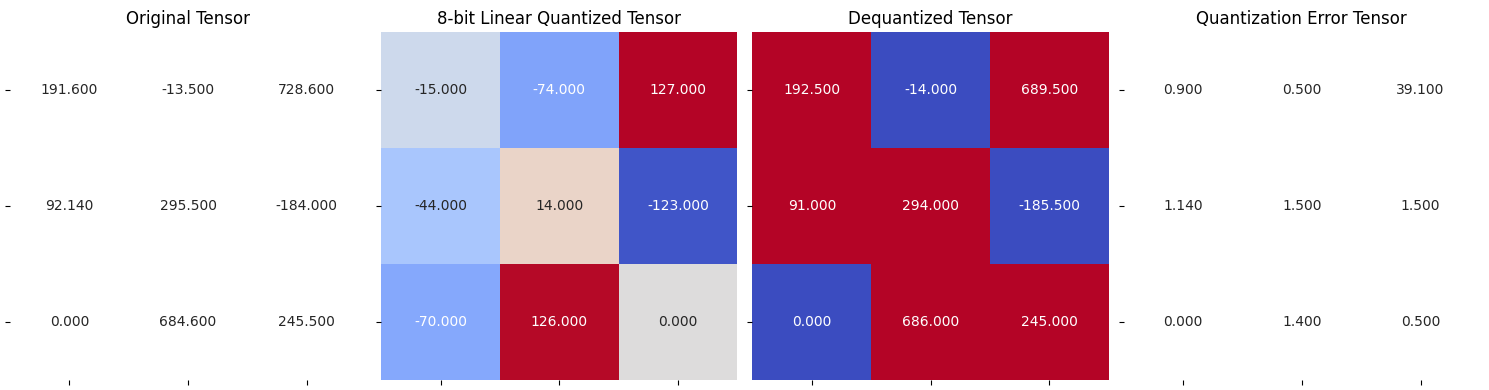

In [11]:
plot_quantization_errors(test_tensor,quantized_tensor,dequantized_tensor)

**Note:** `Quantization Error Tensor = abs(Original Tensor - Dequantized Tensor)`

In [12]:
dequantized_tensor - test_tensor

tensor([[  0.9000,  -0.5000, -39.1000],
        [ -1.1400,  -1.5000,  -1.5000],
        [  0.0000,   1.4000,  -0.5000]])

In [13]:
MSE = Calc_MSE(test_tensor,dequantized_tensor)

In [14]:
print (MSE)

tensor(170.8753)


# Finding `Scale` and `Zero Point` for Quantization
Formula Used:
- $scale = (r_{max}-r_{min})/(q_{max}-q_{min})$
- $zero\_point = (q_{min}-r_{min})/scale$

In [15]:
def get_q_scale_and_zero_point(tensor,dtype = torch.int8):
    q_min = torch.iinfo(dtype).min
    q_max = torch.iinfo(dtype).max
    r_min = tensor.min().item()
    r_max = tensor.max().item()
    scale = (r_max-r_min)/(q_max-q_min)
    zero_point = int(round(q_min-r_min/scale))
    if (zero_point < q_min):
        zero_point = q_min
    if (zero_point > q_max):
        zero_point = q_max
    return scale, zero_point

In [16]:
s,z = get_q_scale_and_zero_point(test_tensor)

In [17]:
print ("Scale =",s, "\nZero_Point =",z)

Scale = 3.578823433670343 
Zero_Point = -77


## Quantization and Dequantization with Calculated `Scale` and `Zero Point`

In [18]:
quantized_tensor = linear_q_with_s_and_z(test_tensor, s, z)

In [19]:
print(quantized_tensor)

tensor([[ -23,  -81,  127],
        [ -51,    6, -128],
        [ -77,  114,   -8]], dtype=torch.int8)


In [20]:
dequantized_tensor = linear_dq_with_s_and_z(quantized_tensor,s,z)

In [21]:
print (dequantized_tensor)

tensor([[ 193.2565,  -14.3153,  730.0800],
        [  93.0494,  297.0423, -182.5200],
        [   0.0000,  683.5552,  246.9388]])


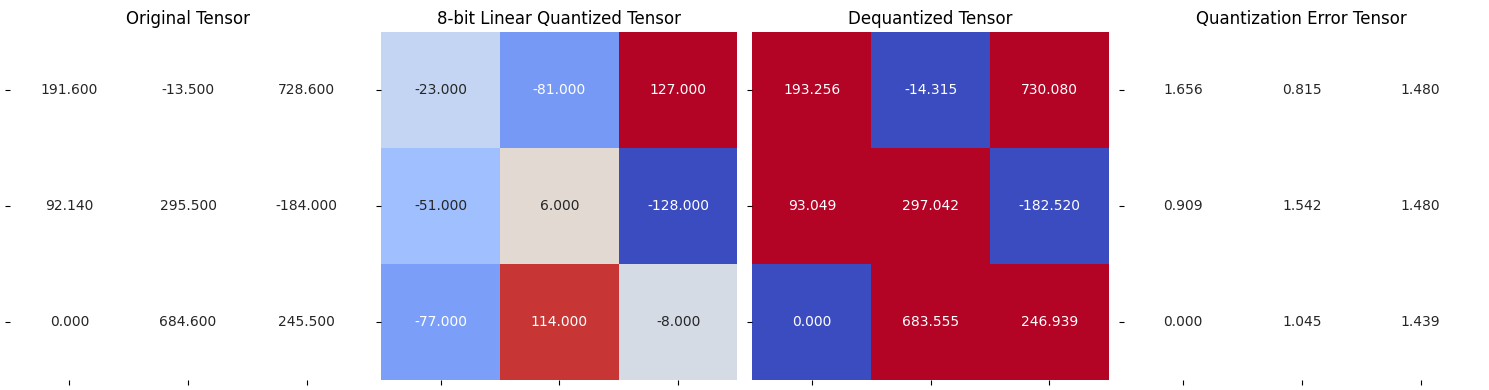

In [22]:
plot_quantization_errors(test_tensor,quantized_tensor,dequantized_tensor)

We can observe that our new MSE has decreased considerably compared to our MSE obtained when using, `Random Scale` and ` Random Zero Point`.

In [23]:
MSE = Calc_MSE(test_tensor,dequantized_tensor)
print (MSE)

tensor(1.5730)


## Combined Fuction to Perform Quantization

In [24]:
def linear_quantization(tensor):
    scale,zero_point = get_q_scale_and_zero_point(tensor)

    quantized_tensor = linear_q_with_s_and_z(tensor,scale,zero_point)
    return quantized_tensor,scale,zero_point

def linear_dequantization(tensor,scale,zero_point,dtype = torch.int8):
    dq_tensor = linear_dq_with_s_and_z(tensor,scale,zero_point)
    return dq_tensor

In [25]:
quantized_tensor,s,z = linear_quantization(test_tensor)
dequantized_tensor = linear_dequantization(quantized_tensor,s,z)
print ("Scale =",s, "\nZero_Point =",z)

Scale = 3.578823433670343 
Zero_Point = -77


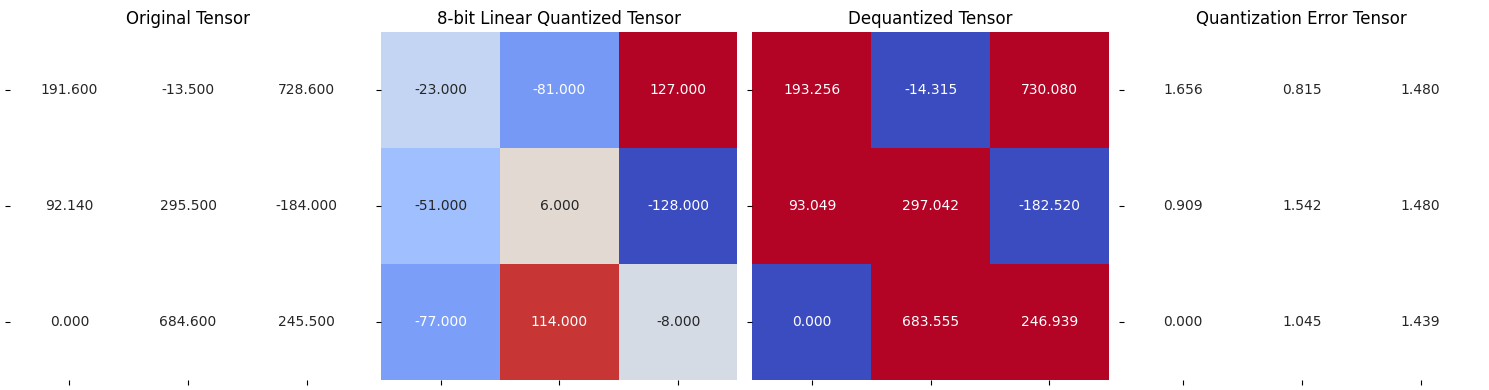

In [26]:
plot_quantization_errors(test_tensor, quantized_tensor, dequantized_tensor)

In [27]:
print (Calc_MSE(test_tensor,dequantized_tensor))

tensor(1.5730)


## Trying Quantization on a Random Input

In [28]:
random_tensor = torch.randn((4, 4))
print (random_tensor)

tensor([[ 0.2621, -0.1686, -0.7649, -1.1477],
        [ 1.1487, -0.1514, -0.8351, -0.0622],
        [ 0.6090,  1.6065,  0.9364, -0.6863],
        [-0.2754,  1.2855, -0.1039,  0.2629]])


In [29]:
quantized_tensor,s,z = linear_quantization(random_tensor)
dequantized_tensor = linear_dequantization(quantized_tensor,s,z)
print ("Scale =",s, "\nZero_Point =",z)

Scale = 0.010800657085343904 
Zero_Point = -22


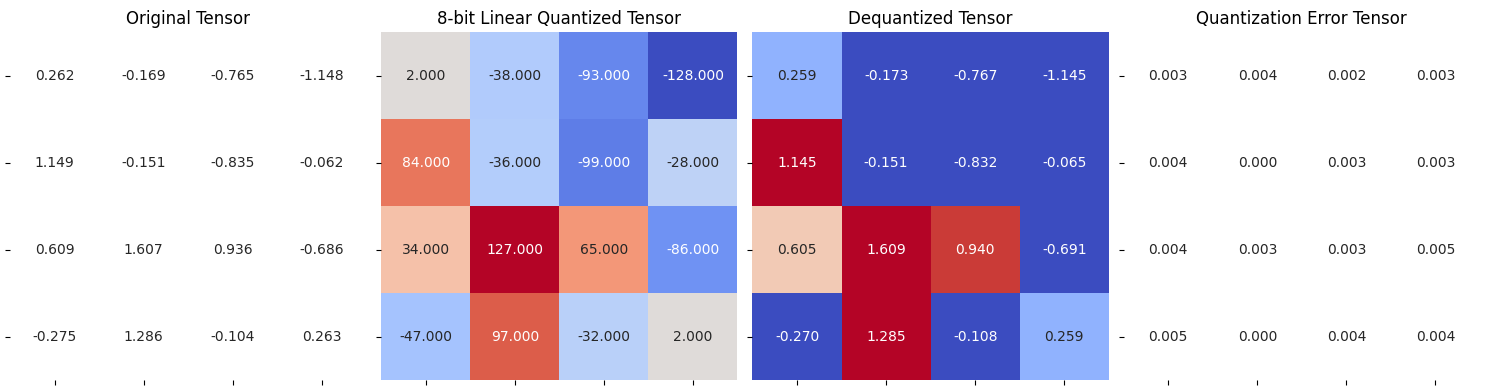

In [30]:
plot_quantization_errors(random_tensor, quantized_tensor, dequantized_tensor)

In [31]:
print (Calc_MSE(random_tensor,dequantized_tensor))

tensor(1.1864e-05)


# Linear Quantization : Symmetric Mode
The quantization performed till now was in `Asymmetric Mode`.
For Symmetric Quantization, $zero\_point = 0$
Formula Used:
- $scale = r_{max}/q_{max}$

In [32]:
def get_q_scale_symmetric(tensor, dtype=torch.int8):
    r_max = tensor.abs().max().item()
    q_max = torch.iinfo(dtype).max
    return r_max/q_max

def linear_quantization_symm(tensor):
    scale = get_q_scale_symmetric(tensor)
    zero_point = 0
    q_tensor = linear_q_with_s_and_z(tensor,scale,zero_point)
    return q_tensor,scale

def linear_dequantization_symm(tensor,s,dtype = torch.int8):
    dq_tensor = linear_dq_with_s_and_z(tensor,s,0)
    return dq_tensor

In [33]:
random_tensor = torch.randn((4, 4))
print (random_tensor)

tensor([[-0.6919, -0.6275,  2.7004, -1.0968],
        [ 0.6844,  0.0155,  0.2000,  1.1649],
        [ 1.5658, -1.2329, -1.5108,  0.3832],
        [ 0.2120, -1.6582, -1.6045,  1.0066]])


In [34]:
s = get_q_scale_symmetric(random_tensor)
z = 0
print ("Scale =",s, "\nZero_Point =",z)

Scale = 0.021263205160306196 
Zero_Point = 0


In [35]:
quantized_tensor,s = linear_quantization_symm(random_tensor)
dequantized_tensor = linear_dequantization_symm(quantized_tensor,s)
print ("Scale =",s)

Scale = 0.021263205160306196


In [36]:
print (dequantized_tensor)

tensor([[-0.7017, -0.6379,  2.7004, -1.1057],
        [ 0.6804,  0.0213,  0.1914,  1.1695],
        [ 1.5735, -1.2333, -1.5097,  0.3827],
        [ 0.2126, -1.6585, -1.5947,  0.9994]])


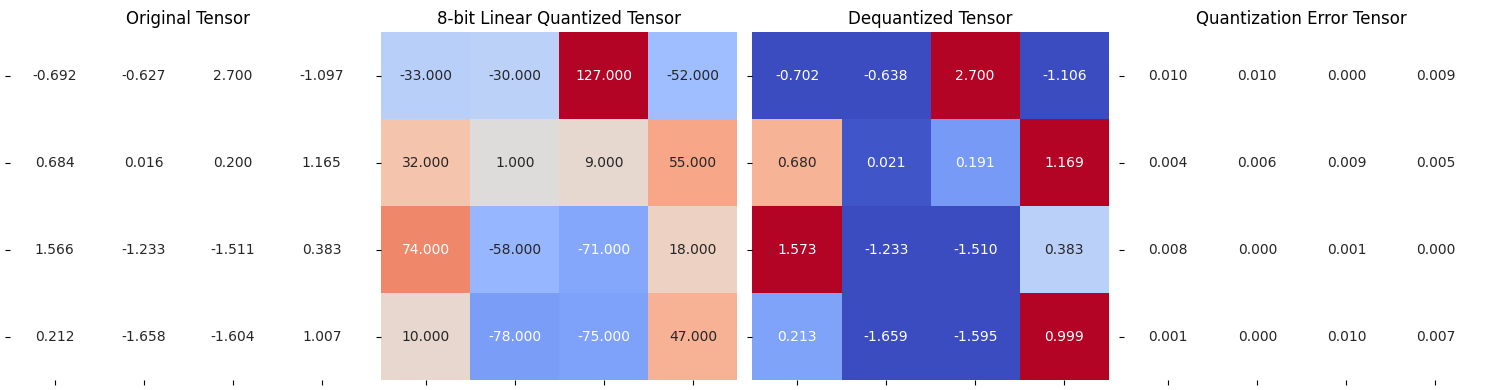

In [37]:
plot_quantization_errors(random_tensor,quantized_tensor, dequantized_tensor)

In [38]:
print(Calc_MSE(random_tensor,dequantized_tensor))

tensor(3.9741e-05)
